In [ ]:
#replace the path of file
!unzip '/content/wetransfer_credit_card_behaviour_scores-docx_2025-01-07_0850 (2).zip'

Archive:  /content/wetransfer_credit_card_behaviour_scores-docx_2025-01-07_0850 (2).zip
replace wetransfer_credit_card_behaviour_scores-docx_2025-01-07_0850/Credit_Card_Behaviour_Scores.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [41]:
# Install necessary libraries
!pip install imblearn
!pip install catboost
!pip install xgboost
!pip install lightgbm

In [ ]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import pickle

In [ ]:
# Load the dataset
dev_data = pd.read_csv('/content/wetransfer_credit_card_behaviour_scores-docx_2025-01-07_0850/Dev_data_to_be_shared.csv')

In [ ]:
# Display the shape
dev_data.shape

(96806, 1216)

In [ ]:
#basic information of the dataset
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96806 entries, 0 to 96805
Columns: 1216 entries, account_number to onus_attribute_48
dtypes: float64(1189), int64(27)
memory usage: 898.1 MB


In [ ]:
dev_data.columns

Index(['account_number', 'bad_flag', 'onus_attribute_1',
       'transaction_attribute_1', 'transaction_attribute_2',
       'transaction_attribute_3', 'transaction_attribute_4',
       'transaction_attribute_5', 'transaction_attribute_6',
       'transaction_attribute_7',
       ...
       'bureau_enquiry_47', 'bureau_enquiry_48', 'bureau_enquiry_49',
       'bureau_enquiry_50', 'onus_attribute_43', 'onus_attribute_44',
       'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47',
       'onus_attribute_48'],
      dtype='object', length=1216)

In [ ]:
# Check for null values in the dataset
dev_data.isnull().sum()

,0
account_number,0
bad_flag,0
onus_attribute_1,25231
transaction_attribute_1,25231
transaction_attribute_2,25231
...,...
onus_attribute_44,85196
onus_attribute_45,85196
onus_attribute_46,85196
onus_attribute_47,85196


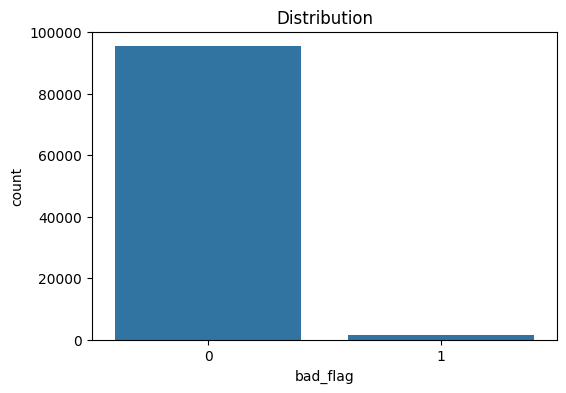

In [ ]:
# Visualize the target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='bad_flag', data=dev_data)
plt.title('Distribution')
plt.show()

In [ ]:
# Check the value counts of the target variable
dev_data['bad_flag'].value_counts()

,count
bad_flag,
0,95434
1,1372


In [ ]:
df = dev_data

In [ ]:

# Define columns to exclude from the imputation process
exclude_columns = ['account_number', 'bad_flag','bureau_436', 'bureau_447']

# Identify numerical columns for processing (excluding specific columns)
numerical_columns = df.columns
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

# Filter columns that are numerical and have at least some data (not completely missing)
numerical_columns_with_data = [col for col in numerical_columns if df[col].isnull().sum() < len(df)]

# Create an imputer to fill missing values using the median of each column
numerical_imputer = SimpleImputer(strategy='median')

# Apply median imputation to the selected columns with missing values
df[numerical_columns_with_data] = numerical_imputer.fit_transform(df[numerical_columns_with_data])

# Print the count of missing values after imputation to confirm the process was successful
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
account_number             0
bad_flag                   0
onus_attribute_1           0
transaction_attribute_1    0
transaction_attribute_2    0
                          ..
onus_attribute_44          0
onus_attribute_45          0
onus_attribute_46          0
onus_attribute_47          0
onus_attribute_48          0
Length: 1216, dtype: int64


In [ ]:
# Display the shape (number of rows and columns) of the DataFrame
df.shape

(96806, 1216)

In [ ]:
# Display the count of missing values for each column in the original DataFrame (dev_data)
dev_data.isnull().sum()

,0
account_number,0
bad_flag,0
onus_attribute_1,0
transaction_attribute_1,0
transaction_attribute_2,0
...,...
onus_attribute_44,0
onus_attribute_45,0
onus_attribute_46,0
onus_attribute_47,0


In [ ]:
# Separate features (X) and target variable (y) from the dataset
# Drop 'account_number' (identifier) and 'bad_flag' (target) columns from the features
X = df.drop(['account_number', 'bad_flag'], axis=1)

# Assign the target variable 'bad_flag' to y
y = df['bad_flag']

In [ ]:
# Identify columns in the dataset that still contain missing values
missing_columns = df.columns[df.isnull().any()]
print(missing_columns)


Index(['bureau_436', 'bureau_447'], dtype='object')


In [ ]:
# Prepare features (X) and target (y)
X = df.drop(['account_number', 'bad_flag', 'bureau_436', 'bureau_447'], axis=1)
y = df['bad_flag']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [ ]:
print(f"Original dataset size: {X_train.shape[0]}")
print(f"Resampled dataset size: {X_train_resampled.shape[0]}")

print(f"Training set size: {X_train_resampled.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Original dataset size: 77444
Resampled dataset size: 152684
Training set size: 152684
Test set size: 19362


In [ ]:
# Assign the resampled training data to variables for further splitting
# X contains the features, and y contains the target variable after SMOTE balancing
X = X_train_resampled
y = y_train_resampled

# Further split the resampled training data into a smaller training set (X_train, y_train)
# and a temporary validation set (X_t, y_t) for model evaluation
# Stratified splitting ensures that the class distribution remains balanced in both sets
X_train, X_t, y_train, y_t = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features for improved model performance
# StandardScaler scales the data to have a mean of 0 and standard deviation of 1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a dictionary of models to train and evaluate
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    # "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=np.sum(y == 0) / np.sum(y == 1), random_state=42),
    # "LightGBM": lgb.LGBMClassifier(class_weight='balanced', random_state=42),
    # "CatBoost": CatBoostClassifier(auto_class_weights='Balanced', verbose=0, random_state=42)
}


Training Random Forest
Random Forest - AUC: 0.9994, F1 Score: 0.9942
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15269
           1       1.00      0.99      0.99     15268

    accuracy                           0.99     30537
   macro avg       0.99      0.99      0.99     30537
weighted avg       0.99      0.99      0.99     30537


Confusion Matrix for Random Forest:
[[15268     1]
 [  175 15093]]

Summary of Model Performance:
Random Forest: AUC = 0.9994, F1 Score = 0.9942

Summary of Model Performance:
Random Forest: AUC = 0.9994, F1 Score = 0.9942


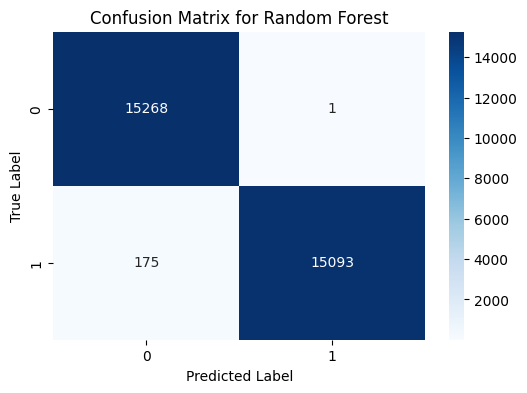

Random Forest model saved to Random Forest_model.sav


In [ ]:
# Initialize a dictionary to store evaluation results for each model
results = {}

# Iterate through the models dictionary and train each model
for name, model in models.items():
    print(f"\nTraining {name}")

    # Train the model on the training dataset
    model.fit(X_train, y_train)

    # Predict probabilities for the validation dataset
    y_pred_proba = model.predict_proba(X_t)[:, 1]

    # Calculate metrics
    auc = roc_auc_score(y_t, y_pred_proba)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    f1 = f1_score(y_t, y_pred)

    # Print performance metrics for the model
    print(f"{name} - AUC: {auc:.4f}, F1 Score: {f1:.4f}")
    print(classification_report(y_t, y_pred))

    # Compute and store the confusion matrix for the model
    cm = confusion_matrix(y_t, y_pred)
    results[name] = {"AUC": auc, "F1 Score": f1, "Confusion_matrix": cm}

    print(f"\nConfusion Matrix for {name}:\n{cm}")

# Summarize the performance of all models
print("\nSummary of Model Performance:")
for model_name, metrics in results.items():

    # Print the AUC and F1 Score for each model
    print(f"{model_name}: AUC = {metrics['AUC']:.4f}, F1 Score = {metrics['F1 Score']:.4f}")

    # Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(metrics["Confusion_matrix"], annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Save the trained model to a file using pickle
    filename = f'{model_name}_model.sav'
    pickle.dump(models[model_name], open(filename, 'wb'))
    print(f"{model_name} model saved to {filename}")

Enter the path to your trained model file: /content/Random Forest_model.sav
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     95434
           1       1.00      0.68      0.81      1372

    accuracy                           1.00     96806
   macro avg       1.00      0.84      0.90     96806
weighted avg       1.00      1.00      0.99     96806



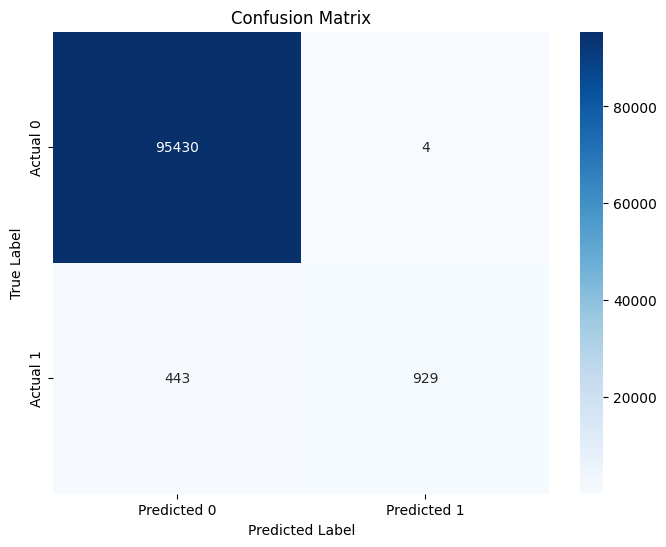

In [ ]:
# Performance evaluation on the original dataset for confirmation

# Define features (X) and target (y) from the original dataset
X = df.drop(['account_number', 'bad_flag', 'bureau_436', 'bureau_447'], axis=1)
y = df['bad_flag']

# Prompt user to provide the path to the saved model file
model_path = input("Enter the path to your trained model file: ")

try:
      # Load the saved model from the specified path
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Use the loaded model to make predictions on the original dataset
    y_pred = model.predict(X)
    y_pred_proba = model.predict_proba(X)[:, 1]

    # Compute evaluation metrics
    auc = roc_auc_score(y, y_pred_proba)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Print the classification report
    print(classification_report(y, y_pred))

    # Compute the confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Visualize the confusion matrix as a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Handle cases where the model file is not found
except FileNotFoundError:
    print(f"Error: Model file not found at {model_path}")

# Handle any other unexpected errors
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
# Load validation data
val_data= pd.read_csv('/content/wetransfer_credit_card_behaviour_scores-docx_2025-01-07_0850/validation_data_to_be_shared.csv')

In [ ]:
# Check the shape of the validation dataset
val_data.shape

(41792, 1215)

In [ ]:
# Display detailed information about the validation dataset
val_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41792 entries, 0 to 41791
Columns: 1215 entries, account_number to onus_attribute_48
dtypes: float64(1189), int64(26)
memory usage: 387.4 MB


In [ ]:
# List all column names in the validation dataset
val_data.columns

Index(['account_number', 'onus_attribute_1', 'transaction_attribute_1',
       'transaction_attribute_2', 'transaction_attribute_3',
       'transaction_attribute_4', 'transaction_attribute_5',
       'transaction_attribute_6', 'transaction_attribute_7',
       'transaction_attribute_8',
       ...
       'bureau_enquiry_47', 'bureau_enquiry_48', 'bureau_enquiry_49',
       'bureau_enquiry_50', 'onus_attribute_43', 'onus_attribute_44',
       'onus_attribute_45', 'onus_attribute_46', 'onus_attribute_47',
       'onus_attribute_48'],
      dtype='object', length=1215)

In [ ]:
# Prepare validation features by dropping irrelevant columns
X = val_data.drop(['account_number', 'bureau_436', 'bureau_447'], axis=1)

# Define the path to the saved model
model_path = '/content/Random Forest_model.sav'

try:
    # Attempt to load the trained model from the specified file path
    with open(model_path, 'rb') as file:
        model = pickle.load(file)

    # Predict the target variable ('bad_flag') for the validation dataset using the loaded model
    y_pred = model.predict(X)

except FileNotFoundError:
    # Handle the case when the model file is not found at the specified path
    print(f"Error: Model file not found at {model_path}")
except Exception as e:
    # Handle any other exceptions that might occur during the process
    print(f"An error occurred: {e}")

# Print the predictions made by the model on the validation dataset
print(y_pred)

[0 0 0 ... 0 0 0]


In [ ]:
# Convert the predictions into a DataFrame with a single column 'bad_flag'
y_pred_df = pd.DataFrame({'bad_flag': y_pred})

# Display the DataFrame containing the predictions
y_pred_df

,bad_flag
0,0
1,0
2,0
3,0
4,0
...,...
41787,0
41788,0
41789,0
41790,0


In [ ]:
# Create a DataFrame containing the predictions
y_pred_df = pd.DataFrame({'bad_flag': y_pred})

# Merge the 'account_number' column from the validation dataset with the 'bad_flag' predictions
merged_df = pd.concat([val_data['account_number'], y_pred_df], axis=1)

# Display the merged DataFrame containing 'account_number' and predicted 'bad_flag'
merged_df

,account_number,bad_flag
0,100001,0
1,100002,0
2,100003,0
3,100004,0
4,100005,0
...,...,...
41787,141788,0
41788,141789,0
41789,141790,0
41790,141791,0


In [ ]:
# Save the merged DataFrame containing account numbers and predicted bad flags to a CSV file
merged_df.to_csv('predicted_bad_flags.csv', index=False)

In [ ]:
# Display the distribution of the predicted 'bad_flag' values (0 or 1)
merged_df['bad_flag'].value_counts()

,count
bad_flag,
0,41430
1,362
